In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import auxiliary as aux

# Load data

In [2]:
# Load the file
df = pd.read_csv('owid-covid-data.csv')

In [3]:
# Check the dimensions
orig_obs, orig_cols = df.shape
df.shape

(394167, 67)

In [4]:
# Check the head
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [5]:
# Check column names
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# Clean data

### Time

In [6]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [7]:
# Check time span
min_date, max_date = df['date'].min(), df['date'].max()
print(f'Min year/month: {min_date.year}/{min_date.month}')
print(f'Max year/month: {max_date.year}/{max_date.month}')
dates = [(year, month) for year in range(min_date.year, max_date.year) for month in range(1, 13)] + [(max_date.year, month) for month in range(1, max_date.month + 1)]

Min year/month: 2020/1
Max year/month: 2024/4


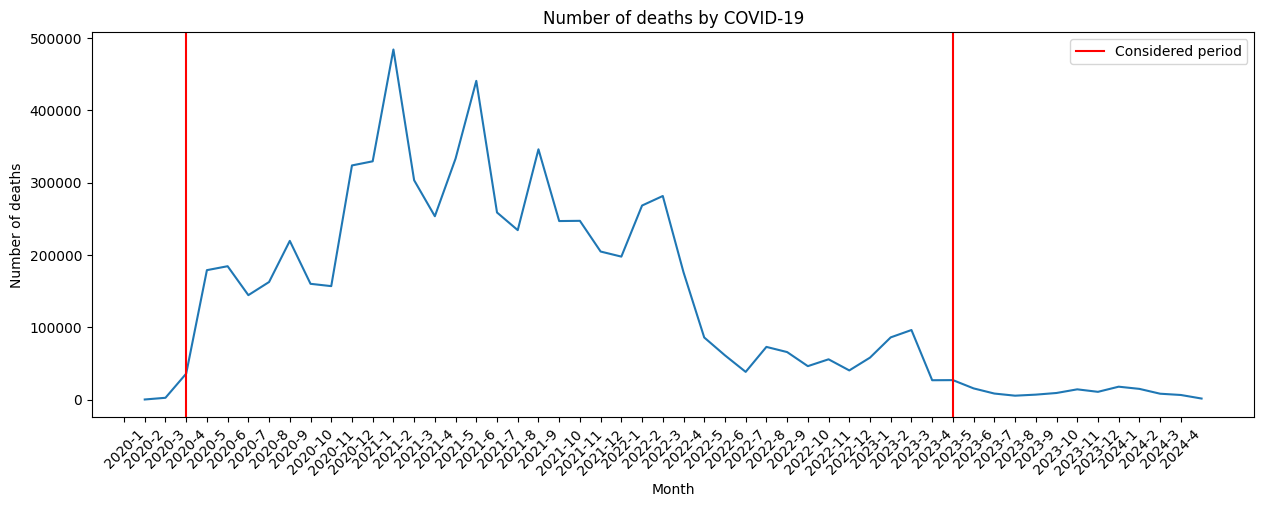

In [8]:
# Plot the number of cases over time
plt.figure(figsize=(15,5))
df.loc[df['location'] == 'World',:].groupby([df['date'].dt.year, df['date'].dt.month])['new_deaths'].sum().plot(xlabel='Month', ylabel='Number of deaths', label='')
plt.axvline(dates.index((2020, 3)), color='red', label='Considered period')
plt.axvline(dates.index((2023, 4)), color='red')
ticks = plt.xticks(np.arange(-1, len(dates)-1), [f'{date[0]}-{date[1]}' for date in dates], rotation=45)
plt.title('Number of deaths by COVID-19')
plt.legend()

In [9]:
# Retaing only the required period
date_filter_mask = (df['date'] >= pd.to_datetime('2020-03-01')) & (df['date'] <= pd.to_datetime('2023-04-30'))
print(f'Dropped {sum(~date_filter_mask)} ({sum(~date_filter_mask) / orig_obs:.2%}) observations outside of the time span')
df = df.loc[date_filter_mask, :]

Dropped 101433 (25.73%) observations outside of the time span


### Location

In [10]:
# Retain only countries
locations_to_drop = ['Asia', 'Africa', 'Europe', 'European Union', 'England', 'High income', 'Low income', 'Lower middle income', 'North America',
                      'Oceania', 'Scotland', 'South America', 'Upper middle income', 'World', 'Northern Ireland']
location_mask = ~df['location'].isin(locations_to_drop)
print(f'Number of locations to drop: {len(locations_to_drop)}')
print(f'Original number of unique locations: {df['location'].nunique()}')
df = df.loc[location_mask, :]
print(f'Final number of unique locations: {df['location'].nunique()}')
print(f'Observations dropped: {sum(~location_mask)} ({sum(~location_mask) / orig_obs:.2%})')

Number of locations to drop: 15
Original number of unique locations: 255
Final number of unique locations: 240
Observations dropped: 17306 (4.39%)


### Drop columns

In [11]:
# Drop obsolete columns
df.drop(['iso_code', 'continent'], axis=1, inplace=True)

### Aggregate monthly

In [12]:
# Retain only last observation for each month
df['year'], df['month'], df['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
month_dates = pd.to_datetime(df.groupby(['year', 'month'])['day'].max().reset_index())
df_monthly = df.loc[df['date'].isin(month_dates), :]

In [13]:
# Retain only useful columns
df_monthly = df_monthly.loc[:, ['location', 'year', 'month', 'total_cases', 'total_deaths', 'reproduction_rate', 'icu_patients', 'hosp_patients', 'weekly_icu_admissions',
                                 'weekly_hosp_admissions', 'total_tests', 'positive_rate', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
                                 'total_boosters', 'stringency_index', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                    'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
                                     'life_expectancy', 'human_development_index', 'population']]


In [14]:
# Set index
df_monthly.set_index(['location', 'year', 'month'], inplace=True)

In [15]:
# Sum relevant variables over month
monthly_sum = df.groupby(['location', 'year', 'month'])[['new_cases', 'new_deaths', 'new_tests', 'new_vaccinations']].sum()
df_monthly = df_monthly.merge(monthly_sum, 'left', left_index=True, right_index=True)

### Drop empty columns

In [16]:
# Drop missing columns
missing_threshold = 0.2
non_missing_cols = (df_monthly.isna().sum() / df_monthly.shape[0]).sort_values(ascending=False) <= missing_threshold
non_missing_cols = list(non_missing_cols.index[non_missing_cols])
print(f'Dropped {df_monthly.shape[1] - len(non_missing_cols)} columns out of {df_monthly.shape[1] - 2}')
df_monthly = df_monthly.loc[:, non_missing_cols]

Dropped 18 columns out of 31


### Correlation analysis

In [17]:
# Get correlations
corr_mat = aux.get_correlations(df_monthly)
corr_mat.head(20)

,FEATURE_1,FEATURE_2,CORRELATION
3,aged_65_older,aged_70_older,0.994197
4,aged_65_older,median_age,0.914577
49,aged_70_older,median_age,0.901151
98,total_deaths,total_cases,0.834103
69,median_age,life_expectancy,0.832674
9,aged_65_older,life_expectancy,0.732969
54,aged_70_older,life_expectancy,0.710601
24,gdp_per_capita,life_expectancy,0.682730
19,gdp_per_capita,median_age,0.648131
193,new_deaths,new_tests,0.577510


In [18]:
# Drop correlated columns
main_vars = list(df_monthly.columns)
corr_cols = ['aged_65_older', 'aged_70_older']
df_monthly.drop(corr_cols, axis=1, inplace=True)
main_vars.remove('aged_65_older')
main_vars.remove('aged_70_older')

In [19]:
# Drop missing rows
print(f'Dropping rows with missing observations: {sum(df_monthly.isna().sum(axis=1) > 0)} ({sum(df_monthly.isna().sum(axis=1) > 0) / df_monthly.shape[0]:.2%})')
df_monthly.dropna(axis=0, inplace=True)

Dropping rows with missing observations: 2644 (29.20%)


# Engineer features

### Scale relevant features by population

In [20]:
# Scale features by population
# df_monthly['population_thousands'] = df_monthly['population'] / 1_000
# df_monthly.drop(columns=['population'], inplace=True) # Drop unnecessary column
# for col in ['total_deaths', 'total_cases', 'new_cases', 'new_deaths', 'new_tests', 'new_vaccinations']:
#     df_monthly[f'{col}_per_thousand'] = df_monthly[col] / df_monthly['population_thousands']

### Dummies for month and country

In [21]:
# Create dummines for month and country
df_monthly.reset_index(drop=False, inplace=True)
df_monthly['date'] = df_monthly['year'].astype(str) + '-' + df_monthly['month'].astype(str)
df_monthly.drop(columns=['year', 'month'], inplace=True)
df_monthly = pd.get_dummies(df_monthly, columns=['date', 'location'], drop_first=True, dtype=int)

# Inspect data

### Check distributions

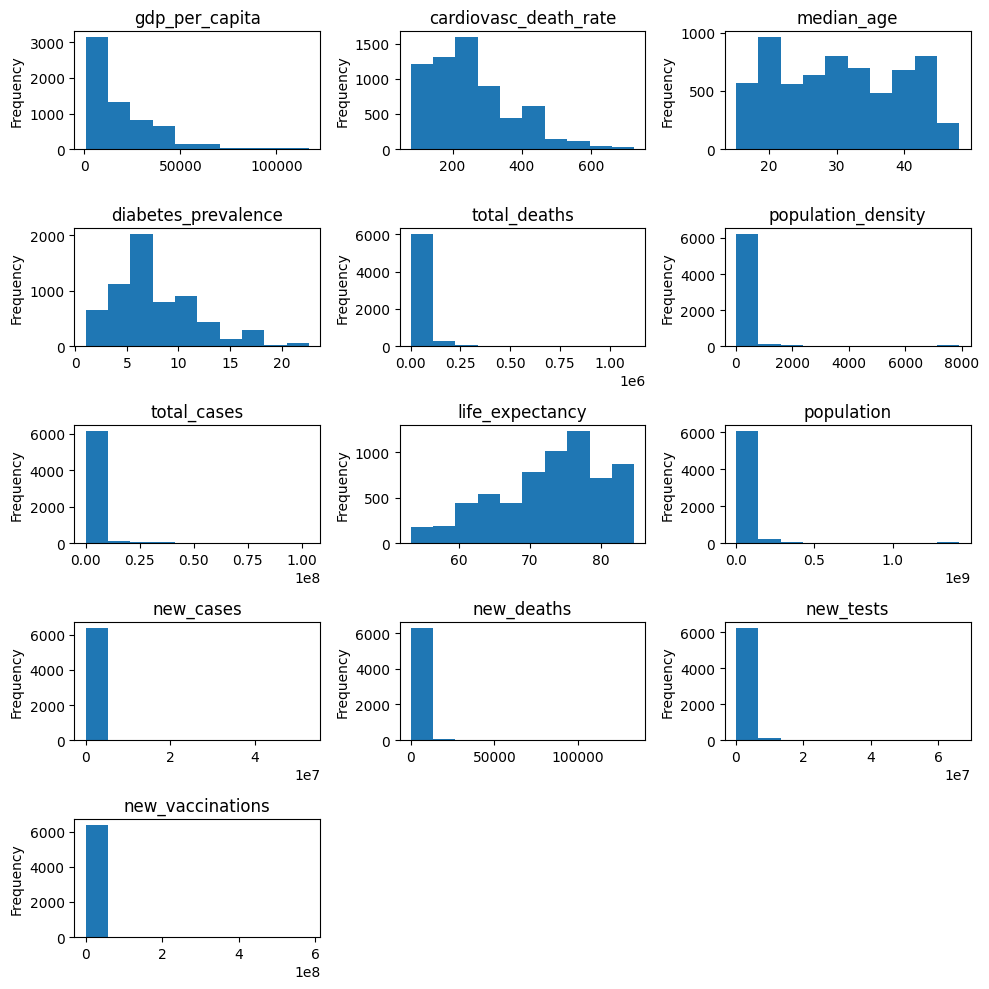

In [22]:
# Plot histograms
nrows, ncols = 5, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
ax = ax.flatten()
for idx, col in enumerate(main_vars):
    df_monthly[col].plot.hist(title=col, ax=ax[idx])

# Hide empty plots
for idx_plot in range(len(main_vars), nrows * ncols):
    ax[idx_plot].set_visible(False)

# Increase spacing between plots
fig.tight_layout()

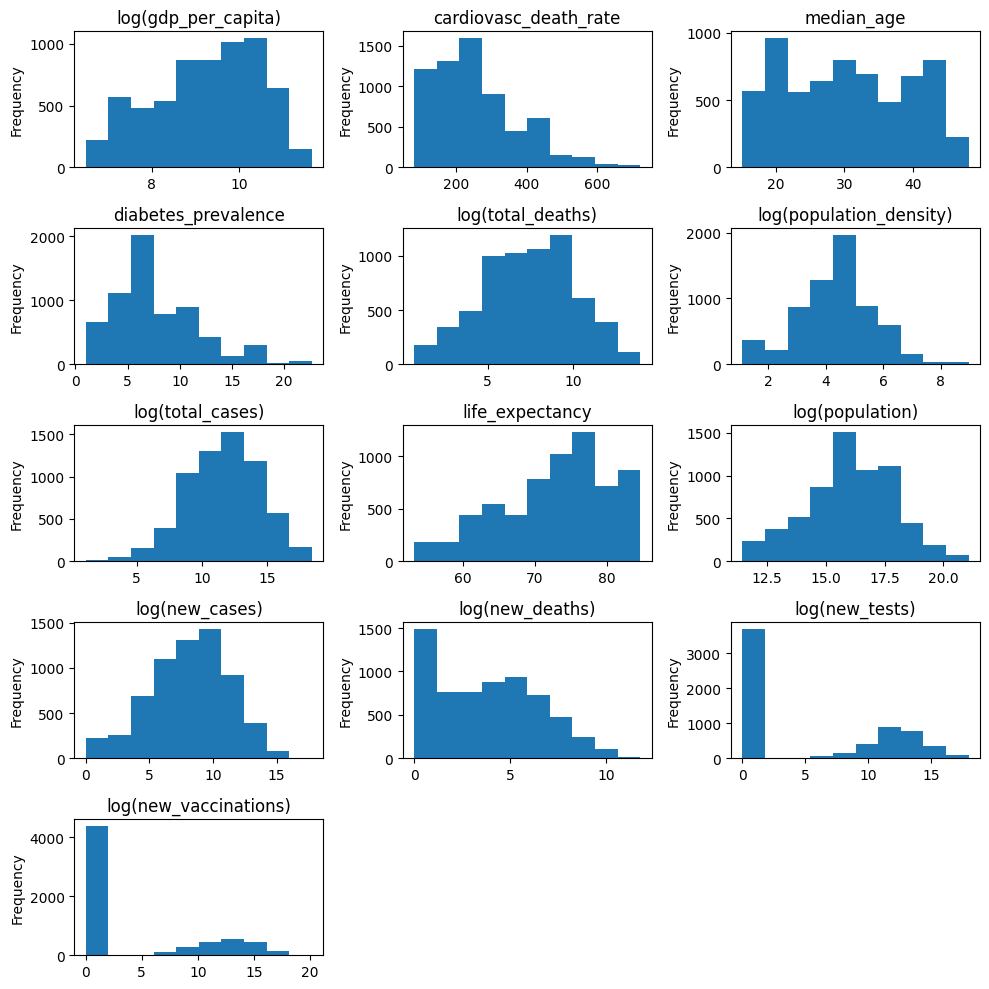

In [23]:
# Plot histogram of logarithmized relevant variables
non_log_cols = ['life_expectancy', 'diabetes_prevalence', 'median_age', 'cardiovasc_death_rate']
nrows, ncols = 5, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
ax = ax.flatten()
for idx, col in enumerate(main_vars):
    if col  not in non_log_cols:
        np.log(df_monthly[col]+1).plot.hist(title=f'log({col})', ax=ax[idx])
    else:
        df_monthly[col].plot.hist(title=col, ax=ax[idx])

# Hide empty plots
for idx_plot in range(len(main_vars), nrows * ncols):
    ax[idx_plot].set_visible(False)

# Increase spacing between plots
fig.tight_layout()

In [25]:
# Create a log version of the data set
df_monthly_log = df_monthly.copy()
for col in main_vars:
    if col not in non_log_cols:
        df_monthly_log[col] = np.log(df_monthly[col] + 1)

In [29]:
# Save the cleaned versions of the data set
df_monthly.to_csv('df_monthly.csv', index=False, sep=';')
df_monthly_log.to_csv('df_monthly_log.csv', index=False, sep=';')